In [1]:
import pandas as pd
import seaborn as sns
import requests
from urllib.parse import urlencode
import numpy as np


# Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.



# Вводные данные

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

# Вопросы
1) На какие метрики Вы смотрите в ходе анализа и почему?

2) Имеются ли различия в показателях и с чем они могут быть связаны?

3) Являются ли эти различия статистически значимыми?

4) Стоит ли запускать новую механику на всех пользователей?

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
public_key_group_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
def get_data_cloud(base_url, public_key, sep=';'):
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=sep)

In [4]:
groups = get_data_cloud(base_url, public_key_groups, sep=';')
group_add = get_data_cloud(base_url, public_key_group_add, sep=',')
active_studs = get_data_cloud(base_url, public_key_active_studs, sep=';')
checks = get_data_cloud(base_url, public_key_checks)

In [5]:
active_studs=active_studs.rename(columns={'student_id':'id'})
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
active_studs.shape

(8341, 1)

In [7]:
active_studs.dtypes

id    int64
dtype: object

In [8]:
active_studs.isna().sum()

id    0
dtype: int64

In [9]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [10]:
groups.shape

(74484, 2)

In [11]:
groups.dtypes

id      int64
grp    object
dtype: object

In [12]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [13]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [14]:
group_add.shape

(92, 2)

In [15]:
group_add.dtypes

id      int64
grp    object
dtype: object

In [16]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [17]:
checks=checks.rename(columns={'student_id':'id'})
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
checks.shape

(541, 2)

In [19]:
checks.dtypes

id       int64
rev    float64
dtype: object

In [20]:
checks.isna().sum()

id     0
rev    0
dtype: int64

Проверка данные показала, что нулей нет, формат данных верные.

объединим все данные по группам (оригинальный + дополненные):

In [21]:
groups_merge = pd.concat([groups, group_add], ignore_index=True )

In [22]:
groups_merge.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [23]:
groups_merge.shape

(74576, 2)

In [24]:
groups_merge.isna().sum()

id     0
grp    0
dtype: int64

проверка на дубликаты:

In [25]:
groups_merge[groups_merge.duplicated ()]

,id,grp


дубликатов и задвоений нету в таблице

Исследуем представленную выборку по группам (все пользователи):

In [26]:
groups_merge.groupby('grp')\
            .agg({'id':'count'}).reset_index()

,grp,id
0,A,14693
1,B,59883


In [27]:
groups_merge.grp.value_counts(normalize=True).mul(100)

B    80.297951
A    19.702049
Name: grp, dtype: float64

Выделим из всей разбивки только тех, кто был активный в дни эксперимента:

In [28]:
active_users = groups_merge[groups_merge.id.isin(active_studs['id'])].reset_index(drop=True)
active_users.head()

,id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B


In [29]:
active_users.shape

(8341, 2)

8341 активных пользователя

Выделим из разбивки тех, кто был неактивный в дни эксперимента:

In [30]:
non_active_users = pd.merge(groups_merge,active_studs, on='id', how='left' , indicator=True)
non_active_users.head()

,id,grp,_merge
0,1489,B,left_only
1,1627,A,both
2,1768,B,left_only
3,1783,B,left_only
4,1794,A,left_only


In [31]:
non_active_users=non_active_users[non_active_users['_merge']=='left_only'].drop('_merge', axis=1)

In [32]:
non_active_users.shape

(66235, 2)

In [33]:
non_active_users_purchase=pd.merge(non_active_users,checks,on='id', how='left')
non_active_users_purchase.head()

,id,grp,rev
0,1489,B,NaN
1,1768,B,NaN
2,1783,B,NaN
3,1794,A,NaN
4,1803,B,NaN


In [34]:
non_active_users_purchase=non_active_users_purchase[non_active_users_purchase['rev']>0]
non_active_users_purchase.head()

,id,grp,rev
36,3185,B,690.0
115,25973,B,690.0
119,26280,B,690.0
212,100645,B,630.0
243,102534,B,580.0


In [35]:
non_active_users_purchase.shape

(149, 3)

In [36]:
non_active_users_purchase.groupby('grp').agg({'id':'count', 'rev':'mean'})

,id,rev
grp,,
A,29,664.689655
B,120,718.800001


Среди неактивных пользователей есть 149 пользователей, которые совершили покупки в выбранные даты

Возвращаемся к активным пользователям:

In [37]:
active_users.groupby('grp')\
            .agg({'id':'count'}).reset_index()

,grp,id
0,A,1538
1,B,6803


In [38]:
active_users.grp.value_counts(normalize=True).mul(100)

B    81.560964
A    18.439036
Name: grp, dtype: float64

In [39]:
# итого мы проверяем на основе выборки в 8341 (активных пользователей), где 18% (1538 пользователей) - контрольная группа

Проверим, кто из них провел оплаты в дни эксперимента - подтянем суммы чеков:

In [40]:
active_users_rev = pd.merge(active_users, checks, on="id", how='left')

In [41]:
active_users_rev.fillna(0, inplace=True)

In [42]:
active_users_rev.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


In [43]:
active_users_rev.nunique()

id     8341
grp       2
rev      39
dtype: int64

In [44]:
active_users_rev.groupby(['rev']).agg({'rev':'count'})
# 392 пользователя сделали покупку из посетивших сайт

,rev
rev,
0.0000,7949
199.0000,32
290.0000,70
398.0000,7
489.0000,3
580.0000,11
590.0000,11
597.0000,1
690.0000,17


In [45]:
# Получили таблицу заказов активных пользователей с суммами чеков по группам:

In [46]:
active_users_rev.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


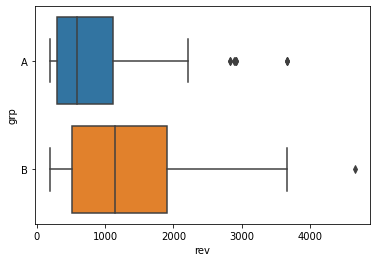

In [47]:
sns.boxplot(data= active_users_rev.query('rev > 0'), x='rev', y = 'grp')
active_users_rev.query('rev > 0').groupby('grp').rev.describe()

In [48]:
active_users_non_zero=active_users_rev.query('rev>0')
active_users_non_zero
# фильтруем по наличию продаж и смотрим распределение

,id,grp,rev
0,1627,A,990.0000
10,100300,B,990.0000
12,108270,B,290.0000
246,264473,B,1900.0001
279,274352,B,690.0000
...,...,...,...
8312,5645737,B,1900.0000
8314,5651566,B,1900.0000
8316,5662322,B,1900.0000
8323,5681918,B,1900.0000


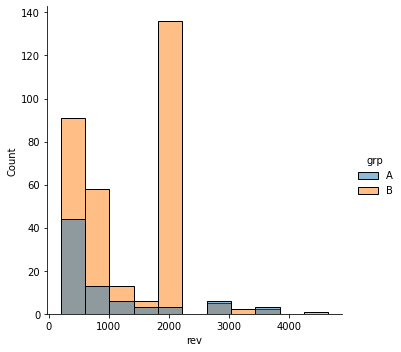

In [49]:
sns.displot(data=active_users_non_zero, x='rev', hue='grp')

Прологарифмируем распредлеление для проверки:

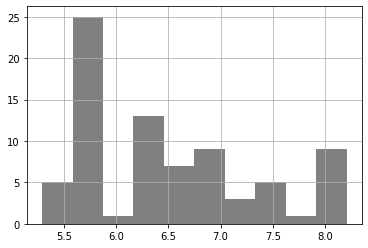

In [50]:
active_users_non_zero.query('grp=="A"').rev.apply(np.log).hist(color="grey", bins=10)

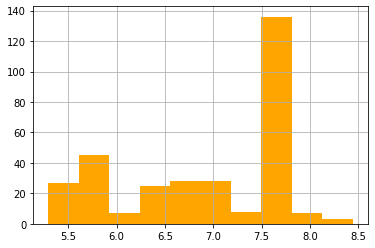

In [51]:
active_users_non_zero.query('grp=="B"').rev.apply(np.log).hist(color="orange", bins=10)

Мы видим, что существуют различия между группами активных пользователей:

    1) средний чек в группе Б выше, максимальная сумма покупки также в 2 раза больше чем в А
    
    2) пользователи охотно совершают покупки в группе Б
    
    3) выбросы так же присутствуют
    
    4) есть неактивные пользователи с продажами (149 человек)
    
    5) распределение не нормальное в обоих группах (на основе выручки, и логарифмированных данных)

# Метрики, которые будем использовать

* **CR** - так как речь идет о продажа, а целевое действие нашего А/Б теста - покупка, то мы будем отслеживать конверсию в покупку активных пользователей,совершивших покупку ко всем пользователям, которые были на сайте.
* **ARPPU** - Средний доход на платящего пользователя. Сколько приносит в среднем 1 платящий пользователь
* **ARPU** - (CR*ARPPU) - Средний доход на активного пользователя.

добавляем данные по наличию продажи в таблицу активных пользователей:

In [52]:
active_users_rev['purchase']=active_users_rev['rev'].apply(lambda x: 1 if x > 0 else 0)
active_users_rev.head()

,id,grp,rev,purchase
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


In [53]:
active_users_rev.shape

(8341, 4)

считаем доход, конверсию, количество пользователей (по выборке из активных):

In [54]:
cr_df=active_users_rev.groupby('grp').\
                        agg({'purchase': 'sum', 
                             'id': 'count',
                             'rev':'sum'}).reset_index()

cr_df=cr_df.rename(columns={'id':'total_users',
                            'purchase':'total_purchases',
                            'rev':'total_rev'})

In [55]:
cr_df['CR']=round(cr_df['total_purchases']/cr_df['total_users']*100,2)
cr_df

,grp,total_purchases,total_users,total_rev,CR
0,A,78,1538,72820.0000,5.07
1,B,314,6803,394974.0035,4.62


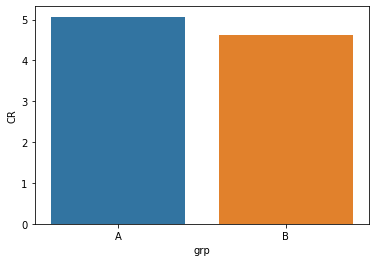

In [56]:
sns.barplot(x=cr_df.grp, y=cr_df.CR)


рассчитываем ARPU (доход/всех пользователей):

In [57]:
cr_df['arpu']=(cr_df['total_rev']/cr_df['total_users']).round(2)
cr_df

,grp,total_purchases,total_users,total_rev,CR,arpu
0,A,78,1538,72820.0000,5.07,47.35
1,B,314,6803,394974.0035,4.62,58.06


рассчитываем ARPPU (доход/платящие пользователей): 

In [58]:
cr_df['arppu']=(cr_df['total_rev']/cr_df['total_purchases']).round(2)
cr_df

,grp,total_purchases,total_users,total_rev,CR,arpu,arppu
0,A,78,1538,72820.0000,5.07,47.35,933.59
1,B,314,6803,394974.0035,4.62,58.06,1257.88


- CR сократилась на 0.45 пункта.
- ARPU и ARPPU выросли 23% и 34% соответственно.

Теперь проверим полученные различия на статистическую значимость при P=5%

In [59]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

import pingouin as pg


# CR
- h0 - значимых различий в конверсии нет, механика оплаты не влияет на конверсию
- h1 - различия в конверсии есть, механика оплаты влияет на конверсию

CR - дискретная переменная, используем Хи-квадрат

In [60]:
active_users_rev.head()

,id,grp,rev,purchase
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


In [61]:
exp, obs, stats=pg.chi2_independence(data=active_users_rev, x='purchase', y='grp')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


- Pval >5% , не отклоняем h0
- Стат. значимых различий между двумя группами в конверсии нет.
- Способ оплаты не влияет на конверсию.

Проверим распределение дохода от пользователей на нормальность для выбора теста:

In [62]:
pg.normality(data = active_users_rev, dv='rev',
                   group='grp', method="normaltest")

# для всех пользователей

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


In [63]:
pg.normality(data = active_users_rev.query('rev>0'), dv='rev',
                   group='grp', method="normaltest")

# только для платящих

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


распределения дохода пользователей не является нормальным

Проверим распределение на гомоскедатичность (сверим дисперсии в группах)

In [64]:
pg.homoscedasticity(active_users_rev.query('rev>0'), dv="rev", group="grp") 
# для всех пользователей

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,W,pval,equal_var
levene,3.075682,0.080257,True


In [65]:
pg.homoscedasticity(active_users_rev, dv="rev", group="grp") 
# только для платящих

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,W,pval,equal_var
levene,1.501461,0.220481,True


В обоих выборках не наблюдается различий в дисперсиях.

Можно использовать t-test:

# ARPU

- h0- значимых различий в ARPU нет, доход от пользователя не зависит от механики оплаты
- h1 -  значимые различия в ARPU есть, механика оплаты влияет на доход от пользователя

ARPU - непрерывная переменная, используем t-test

In [66]:
pg.ttest(active_users_rev[active_users_rev['grp'] == 'A']['rev'],\
                            active_users_rev[active_users_rev['grp'] == 'B']['rev'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286374,2416.748043,two-sided,0.198436,"[-27.04, 5.62]",0.034597,0.073,0.231965


- Pval >5% , не отклоняем h0
- Cтат. значимых различий между двумя группами в ARPU нет

# ARPPU
- h0- значимых различий в ARPPU нет, доход от платящего пользователя не зависит от способа оплаты
- h1 - стат значимые различия в ARPPU есть, доход от платящего пользователя зависит от способа оплаты

ARPPU - непрерывная переменная, используем t-test

In [67]:
pg.ttest(active_users_rev.loc[(active_users_rev['grp'] == 'A') & (active_users_rev['rev'] > 0), 'rev'],
                    active_users_rev.loc[(active_users_rev['grp'] == 'B') & (active_users_rev['rev'] > 0), 'rev'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


- Pval <5% , отклоняем h0
- Cтат. значимые различия в ARPPU между двумя группами есть, механика влияет на размер дохода от платящего пользователя

# Вывод:
- Изменение CR случайно, не стат. значимо
- Изменение ARPU случайно, не стат. значимо
- Изменение ARPPU не случайно - в группе Б есть стат значимые различия, ARPPU у тестовой группы выше.
  Механика оплаты влияет на доход от платящих пользователей. Стоит применить данную механику.

Общие результаты:

1) Мы смотрим на данные по активным пользователям, тестовая группа с новой механикой не показала стат значимых различий по CR, ARPU, только средний доход на платящего пользователя выше в группе Б - так как мы создавали механику оплаты, то эксперимент удался.

2) Реализация подобного эксперимента на всю платформу не повлечет стат. значимых результатов в конверсии, среднему доходу на пользователя, НО увеличит средних доход на платящего пользователя.

3) Также тут есть 149 пользователей, совершивших покупки не заходя на сайт (неактивные) в дни эксперимента.
Как они были совершены без захода на сайт? Через приложение? Подписка?
- 149 (29 + 120) против 392 (78 +314) - почти 30% всех покупок было сделано неактивными пользователями.
- Средняя сумма покупки неактивных пользователей очень похожа между группами ~700, в то время как по активным пользователям чеки сильно варьируются.
- Вероятно в данных некорректно отображается информация по покупкас/списанию оплаты подписки, которая имеет фикс (+/-) 700 руб.

# Задание 2. SQL

# Часть 1.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.



In [68]:
import pandahouse as ph


connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'}


In [69]:
# посмотрим на наши данные PEAS (timestamp в yyyy-mm-dd):
query_peas = '''
        SELECT 
            st_id, correct, toDate(timest) as timest, subject 
        FROM 
            default.peas
        '''
df_peas = ph.read_clickhouse(query_peas, connection=connection_default)
print(df_peas)

        st_id  correct     timest                subject
0      100379        1 2021-10-30  Theory of probability
1      100379        0 2021-10-30          Vizualization
2      100379        1 2021-10-30  Theory of probability
3      100379        1 2021-10-30          Vizualization
4      100379        1 2021-10-30  Theory of probability
...       ...      ...        ...                    ...
13240  996911        1 2021-10-31             Statistics
13241  996911        0 2021-10-31             Statistics
13242  996911        0 2021-10-31             Statistics
13243  996911        1 2021-10-31             Statistics
13244  996911        0 2021-10-31             Statistics

[13245 rows x 4 columns]


In [70]:
# посмотрим на наши данные STUDS:
query_studs = '''
        SELECT 
            st_id, test_grp 
        FROM 
            default.studs
        '''
df_studs = ph.read_clickhouse(query_studs, connection=connection_default)
print(df_studs)

      st_id test_grp
0    100379    pilot
1    101432  control
2    104818    pilot
3    104885    pilot
4    104966    pilot
..      ...      ...
595  988626    pilot
596  993249    pilot
597  994983    pilot
598  996911  control
599  999201    pilot

[600 rows x 2 columns]


In [71]:
# посмотрим на наши данные final_project_check (timestamp в yyyy-mm-dd):
query_final_project_check = '''
        SELECT 
            st_id, toDate(sale_time) as sale_time, money, subject 
        FROM 
            final_project_check
        '''
df_final_project = ph.read_clickhouse(query_final_project_check, connection=connection_default)
print(df_final_project)

     st_id  sale_time   money        subject
0   101432 2021-10-31   85000           Math
1   101432 2021-10-31   65000  Vizualization
2   104885 2021-10-30   65000  Vizualization
3   104885 2021-10-30   75000     Statistics
4   106464 2021-10-31   85000           Math
..     ...        ...     ...            ...
56  969595 2021-10-30   65000  Vizualization
57  969595 2021-10-31   75000     Statistics
58  969595 2021-10-31  100000         Python
59  976866 2021-10-30   85000           Math
60  982100 2021-10-30   85000           Math

[61 rows x 4 columns]


In [72]:
# посчитаем количество учеников, сделавших больше 20 заданий:
q1 = '''
    SELECT 
        count(distinct(st_id)) as good_students
    FROM 
    (
        SELECT st_id
        FROM default.peas
        WHERE correct=1 
        GROUP BY st_id, correct, toStartOfMonth(timest)
        HAVING sum(correct) >=20)
    '''

q_1 = ph.read_clickhouse(query=q1, connection=connection_default)
q_1

,good_students
0,136


Всего 136 учеников решили верно больше 20 задач.

# Часть 2.

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.


Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


In [73]:
task_2 = '''
    WITH
        active_studs as 
            (SELECT 
                distinct peas.st_id
            FROM default.peas
                JOIN
                default.studs
                ON peas.st_id=studs.st_id
            WHERE
                correct = 1
            GROUP BY
                peas.st_id
            HAVING
                sum(correct)>10),
                
        active_studs_math as
            (SELECT 
                distinct peas.st_id
            FROM default.peas
                JOIN
                default.studs
                ON peas.st_id=studs.st_id
            WHERE
                correct = 1 and subject = 'Math'
            GROUP BY
                peas.st_id
            HAVING
                sum(correct)>=2)
    SELECT
        studs.test_grp as test_grp,
        sum(final_project_check.money)/count(distinct(studs.st_id)) as ARPU,
        sumIf(final_project_check.money, final_project_check.st_id == active_studs.st_id)/(count(distinct(active_studs.st_id))-1) as ARPAU,
        round((count(distinct final_project_check.st_id)-1)/(count(distinct studs.st_id)-1)*100,2) as CR,
        round((countIf(distinct active_studs.st_id, final_project_check.money >0)-1)/(count(distinct active_studs.st_id)-1)*100,2) as CR_active,
        round((countIf(distinct active_studs_math.st_id, final_project_check.money >0 AND  final_project_check.subject=='Math')-1)/(count(distinct active_studs_math.st_id)-1)*100,2) as CR_math
    FROM
        studs
        
        FULL JOIN
        final_project_check ON studs.st_id = final_project_check.st_id
            
        FULL JOIN 
        active_studs ON active_studs.st_id = studs.st_id
            
        FULL JOIN
        active_studs_math ON active_studs_math.st_id = studs.st_id
        
    GROUP BY
        studs.test_grp
    '''
task_2_metrics = ph.read_clickhouse(query=task_2, connection=connection_default)
task_2_metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.983607,10393.700787,4.93,11.02,6.12
1,pilot,11508.474576,29739.583333,10.88,26.04,9.52


Новый экран оплаты повлиял на рост всех показателей в группе Pilot.
ARPU вырос в 2.53 раза, ARPAU в 2.86 - улучшилась монетизация. Пользователи стали активнее пользоваться платным сервисом.
Конверсии выросли существенно как вцелом 5.95 пунктов так и для активных пользователей (15 пунктов).
Конверсия в покупку курса по математике (3.4 пункта)


# Часть 3.

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

- CR 
- ARPU
- ARPPU


Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [74]:
groups= pd.read_csv('Проект_2_groups.csv', sep=';')

active_studs = pd.read_csv('Проект_2_active_studs.csv')
active_studs=active_studs.rename(columns={'student_id':'id'})

checks = pd.read_csv('Проект_2_checks.csv',sep=';')
checks=checks.rename(columns={'student_id':'id'})



FileNotFoundError: [Errno 2] No such file or directory: 'Проект_2_groups.csv'

In [ ]:
group_add_link = 'Проект_2_group_add.csv'


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def group_upd(group_add):

    group_add_new = pd.read_csv(group_add_link)
    
    full_group = pd.concat([groups, group_add_new]).drop_duplicates(subset='id')
    full_active=pd.merge(active_studs, full_group, on='id').merge(checks, on='id', how='left')
    
    metrics_df=full_active.groupby('grp', as_index = False).agg(
                                                  uniq_id = ('id', 'nunique' ),
                                                  num_purchase =('rev', 'count'),\
                                                  sum_rev =  ('rev', 'sum'))\
                                                  .fillna(0)\
                                                  .round(2)
    
    metrics_df['CR'] = round(metrics_df['num_purchase']/metrics_df['uniq_id']*100, 2)
    metrics_df['ARPU'] = round(metrics_df['sum_rev']/metrics_df['uniq_id'], 2)
    metrics_df['ARPPU'] = round(metrics_df['sum_rev']/metrics_df['num_purchase'], 2)
    
    
    
    # Построение графиков
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'orange', 'red']

    # График CR
    plt.subplot(2, 2, 1)
    plt.bar(metrics_df['grp'], metrics_df['CR'], color=colors)
    plt.title('Conversion Rate (CR)')
    plt.xlabel('Group')
    plt.ylabel('CR (%)')

    # График ARPU
    plt.subplot(2, 2, 2)
    plt.bar(metrics_df['grp'], metrics_df['ARPU'], color=colors)
    plt.title('Average Revenue per User (ARPU)')
    plt.xlabel('Group')
    plt.ylabel('ARPU')

    # График ARPPU
    plt.subplot(2, 2, 3)
    plt.bar(metrics_df['grp'], metrics_df['ARPPU'], color=colors)
    plt.title('Average Revenue per Paying User (ARPPU)')
    plt.xlabel('Group')
    plt.ylabel('ARPPU')

    plt.tight_layout()  # Чтобы избежать перекрытия графиков
    plt.show()

    return metrics_df

In [ ]:
metrics_df=group_upd(group_add_link)
metrics_df

Значения метрик совпали с расчетом в первом задании. 
Функционал подгрузки файла будет работать, если все апдейт файлы будут находится по по пути: group_add_link